# Task 1 Evaluation

This notebook contains the evaluation for Task 1 of the TREC Fair Ranking track.

## Setup

We begin by loading necessary libraries:

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import binpickle

Set up progress bar and logging support:

In [2]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

In [3]:
import sys, logging
logging.basicConfig(level=logging.INFO, stream=sys.stderr)
log = logging.getLogger('task1-eval')

Set up the RNG:

In [4]:
import seedbank
seedbank.initialize(20220101)
rng = seedbank.numpy_rng()

INFO:seedbank:initialized root seed SeedSequence(
    entropy=20220101,
)


Import metric code:

In [5]:
import metrics
from trecdata import scan_runs

And finally import the metric itself:

In [6]:
metric = binpickle.load('task1-eval-metric.bpk')

## Importing Data

Let's load the runs now:

In [7]:
runs = pd.DataFrame.from_records(row for (task, rows) in scan_runs() if task == 1 for row in rows)
runs

INFO:trecdata:scanning runs\1step_pair.gz
INFO:trecdata:scanning runs\1step_pair_list.gz
INFO:trecdata:scanning runs\2step_pair.gz
INFO:trecdata:scanning runs\2step_pair_list.gz
INFO:trecdata:scanning runs\pl_control_0.6.gz
INFO:trecdata:scanning runs\pl_control_0.8.gz
INFO:trecdata:scanning runs\pl_control_0.92.gz
INFO:trecdata:scanning runs\PL_IRLab_05.gz
INFO:trecdata:scanning runs\PL_IRLab_07.gz
INFO:trecdata:scanning runs\RMITRet.gz
INFO:trecdata:scanning runs\RMITRetRerank_1.gz
INFO:trecdata:scanning runs\RMITRetRerank_2.gz
INFO:trecdata:scanning runs\RUN1.gz
INFO:trecdata:scanning runs\RUN_task2.gz
INFO:trecdata:scanning runs\UoGTrDExpDisLT1.gz
INFO:trecdata:scanning runs\UoGTrDExpDisT1.gz
INFO:trecdata:scanning runs\UoGTrDExpDisT2.gz
INFO:trecdata:scanning runs\UoGTrDivPropT1.gz
INFO:trecdata:scanning runs\UoGTrDivPropT2.gz
INFO:trecdata:scanning runs\UoGTrDRelDiT1.gz
INFO:trecdata:scanning runs\UoGTrDRelDiT2.gz
INFO:trecdata:scanning runs\UoGTrLambT2.gz
INFO:trecdata:scanning 

,run_name,topic_id,rank,page_id
0,1step_pair,101,1,32092783
1,1step_pair,101,2,51173523
2,1step_pair,101,3,38401806
3,1step_pair,101,4,5009851
4,1step_pair,101,5,31487590
...,...,...,...,...
636995,UoGTrRelT1,150,996,42956179
636996,UoGTrRelT1,150,997,13057243
636997,UoGTrRelT1,150,998,3863373
636998,UoGTrRelT1,150,999,7971548


Since we only have annotations for the first 20 for each run, limit the data:

In [8]:
runs = runs[runs['rank'] <= 20]

In [9]:
runs.head()

,run_name,topic_id,rank,page_id
0,1step_pair,101,1,32092783
1,1step_pair,101,2,51173523
2,1step_pair,101,3,38401806
3,1step_pair,101,4,5009851
4,1step_pair,101,5,31487590


## Computing Metrics

We are now ready to compute the metric for each (system,topic) pair.  Let's go!

In [10]:
rank_awrf = runs.groupby(['run_name', 'topic_id'])['page_id'].progress_apply(metric)
rank_awrf = rank_awrf.unstack()
rank_awrf

  0%|          | 0/637 [00:00<?, ?it/s]

nDCG      AWRF     Score
run_name   topic_id                              
1step_pair 101       0.089572  0.763866  0.068421
           102       0.000000  0.570331  0.000000
           103       0.040762  0.728929  0.029713
           104       0.304688  0.917405  0.279522
           105       0.283242  0.750284  0.212512
...                       ...       ...       ...
UoGTrRelT1 146       0.342107  0.584009  0.199793
           147       0.127065  0.588928  0.074832
           148       0.148290  0.826860  0.122615
           149       0.131011  0.840488  0.110113
           150       0.129963  0.541840  0.070419

[637 rows x 3 columns]

Make sure we aren't missing anything:

In [11]:
rank_awrf[rank_awrf['Score'].isnull()]

,,nDCG,AWRF,Score
run_name,topic_id,,,


Now let's average by runs:

In [12]:
run_scores = rank_awrf.groupby('run_name').mean()
run_scores.sort_values('Score', ascending=False, inplace=True)
run_scores

,nDCG,AWRF,Score
run_name,,,
UoGTrDExpDisT1,0.207071,0.829856,0.176150
UoGTrDRelDiT1,0.200079,0.807249,0.163928
UoGTrDivPropT1,0.215731,0.711169,0.153164
UoGTrDExpDisLT1,0.177566,0.819658,0.145930
RUN1,0.216915,0.662699,0.142515
UoGTrRelT1,0.212028,0.655909,0.137256
RMITRet,0.207530,0.641316,0.131652
1step_pair,0.083761,0.694032,0.064822
2step_pair,0.082361,0.694348,0.063843


And bootstrap some confidence intervals:

In [13]:
def boot_ci(col):
    res = bootstrap([col], statistic=np.mean, random_state=rng)
    return pd.Series({
        'Score.SE': res.standard_error,
        'Score.Lo': res.confidence_interval.low,
        'Score.Hi': res.confidence_interval.high,
        'Score.W': res.confidence_interval.high - res.confidence_interval.low
    })

In [14]:
run_score_ci = rank_awrf.groupby('run_name')['Score'].apply(boot_ci).unstack()
run_score_ci

,Score.SE,Score.Lo,Score.Hi,Score.W
run_name,,,,
1step_pair,0.010955,0.046378,0.090294,0.043916
1step_pair_list,0.009942,0.045489,0.084916,0.039427
2step_pair,0.010861,0.045420,0.089071,0.043651
2step_pair_list,0.009842,0.043836,0.082544,0.038709
RMITRet,0.012234,0.110051,0.159193,0.049143
RMITRetRerank_1,0.001564,0.000681,0.008812,0.008130
RMITRetRerank_2,0.001515,0.000641,0.008723,0.008081
RUN1,0.013317,0.119162,0.171547,0.052385
UoGTrDExpDisLT1,0.013062,0.121540,0.172961,0.051422


In [15]:
run_score_full = run_scores.join(run_score_ci)
run_score_full

,nDCG,AWRF,Score,Score.SE,Score.Lo,Score.Hi,Score.W
run_name,,,,,,,
UoGTrDExpDisT1,0.207071,0.829856,0.176150,0.017200,0.144649,0.211917,0.067268
UoGTrDRelDiT1,0.200079,0.807249,0.163928,0.014077,0.138033,0.193039,0.055006
UoGTrDivPropT1,0.215731,0.711169,0.153164,0.014245,0.127743,0.184355,0.056612
UoGTrDExpDisLT1,0.177566,0.819658,0.145930,0.013062,0.121540,0.172961,0.051422
RUN1,0.216915,0.662699,0.142515,0.013317,0.119162,0.171547,0.052385
UoGTrRelT1,0.212028,0.655909,0.137256,0.013172,0.112827,0.165056,0.052230
RMITRet,0.207530,0.641316,0.131652,0.012234,0.110051,0.159193,0.049143
1step_pair,0.083761,0.694032,0.064822,0.010955,0.046378,0.090294,0.043916
2step_pair,0.082361,0.694348,0.063843,0.010861,0.045420,0.089071,0.043651


In [16]:
run_tbl_df = run_score_full[['nDCG', 'AWRF', 'Score']].copy()
run_tbl_df['95% CI'] = run_score_full.apply(lambda r: "(%.3f, %.3f)" % (r['Score.Lo'], r['Score.Hi']), axis=1)
run_tbl_df

,nDCG,AWRF,Score,95% CI
run_name,,,,
UoGTrDExpDisT1,0.207071,0.829856,0.176150,"(0.145, 0.212)"
UoGTrDRelDiT1,0.200079,0.807249,0.163928,"(0.138, 0.193)"
UoGTrDivPropT1,0.215731,0.711169,0.153164,"(0.128, 0.184)"
UoGTrDExpDisLT1,0.177566,0.819658,0.145930,"(0.122, 0.173)"
RUN1,0.216915,0.662699,0.142515,"(0.119, 0.172)"
UoGTrRelT1,0.212028,0.655909,0.137256,"(0.113, 0.165)"
RMITRet,0.207530,0.641316,0.131652,"(0.110, 0.159)"
1step_pair,0.083761,0.694032,0.064822,"(0.046, 0.090)"
2step_pair,0.082361,0.694348,0.063843,"(0.045, 0.089)"


Combine them:

In [17]:
run_tbl_fn = Path('figures/task1-runs.tex')
run_tbl = run_tbl_df.to_latex(float_format="%.4f", bold_rows=True, index_names=False)
run_tbl_fn.write_text(run_tbl)
print(run_tbl)

\begin{tabular}{lrrrl}
\toprule
{} &   nDCG &   AWRF &  Score &          95\% CI \\
\midrule
\textbf{UoGTrDExpDisT1 } & 0.2071 & 0.8299 & 0.1761 &  (0.145, 0.212) \\
\textbf{UoGTrDRelDiT1  } & 0.2001 & 0.8072 & 0.1639 &  (0.138, 0.193) \\
\textbf{UoGTrDivPropT1 } & 0.2157 & 0.7112 & 0.1532 &  (0.128, 0.184) \\
\textbf{UoGTrDExpDisLT1} & 0.1776 & 0.8197 & 0.1459 &  (0.122, 0.173) \\
\textbf{RUN1           } & 0.2169 & 0.6627 & 0.1425 &  (0.119, 0.172) \\
\textbf{UoGTrRelT1     } & 0.2120 & 0.6559 & 0.1373 &  (0.113, 0.165) \\
\textbf{RMITRet        } & 0.2075 & 0.6413 & 0.1317 &  (0.110, 0.159) \\
\textbf{1step\_pair     } & 0.0838 & 0.6940 & 0.0648 &  (0.046, 0.090) \\
\textbf{2step\_pair     } & 0.0824 & 0.6943 & 0.0638 &  (0.045, 0.089) \\
\textbf{1step\_pair\_list} & 0.0820 & 0.6908 & 0.0623 &  (0.045, 0.085) \\
\textbf{2step\_pair\_list} & 0.0786 & 0.6912 & 0.0607 &  (0.044, 0.083) \\
\textbf{RMITRetRerank\_1} & 0.0035 & 0.6180 & 0.0026 &  (0.001, 0.009) \\
\textbf{RMITRetRerank\_2

## Analyzing Scores

What is the distribution of scores?

In [18]:
run_scores.describe()

,nDCG,AWRF,Score
count,13.000000,13.000000,13.000000
mean,0.136196,0.702470,0.100573
std,0.082475,0.072769,0.060213
min,0.003486,0.615812,0.002558
25%,0.081950,0.655909,0.062319
50%,0.177566,0.691248,0.131652
75%,0.207530,0.711169,0.145930
max,0.216915,0.829856,0.176150


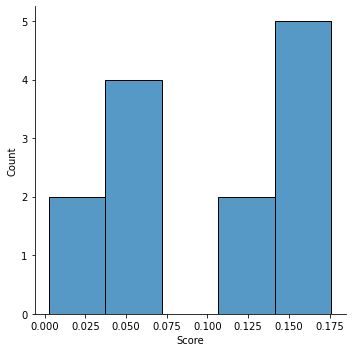

In [19]:
sns.displot(x='Score', data=run_scores)
plt.savefig('figures/task1-score-dist.pdf')
plt.show()

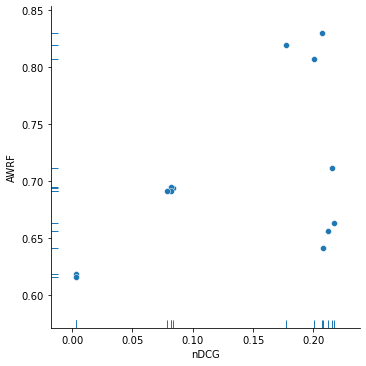

In [20]:
sns.relplot(x='nDCG', y='AWRF', data=run_scores)
sns.rugplot(x='nDCG', y='AWRF', data=run_scores)
plt.savefig('figures/task1-ndcg-awrf.pdf')
plt.show()

## Per-Topic Stats

We need to return per-topic stats to each participant, at least for the score.

In [21]:
topic_stats = rank_awrf.groupby('topic_id').agg(['mean', 'median', 'min', 'max'])
topic_stats

nDCG                                    AWRF            \
              mean    median       min       max      mean    median   
topic_id                                                               
101       0.086105  0.088144  0.073068  0.092355  0.802116  0.799462   
102       0.116518  0.147398  0.000000  0.380490  0.658510  0.605274   
103       0.071175  0.049296  0.040115  0.141229  0.621398  0.721786   
104       0.220206  0.246922  0.000000  0.320596  0.792024  0.830481   
105       0.227029  0.273720  0.000000  0.283242  0.672686  0.699219   
106       0.066962  0.090409  0.000000  0.139760  0.729299  0.694769   
107       0.249331  0.110504  0.000000  0.552509  0.562733  0.533389   
108       0.050961  0.000000  0.000000  0.361088  0.665913  0.674844   
109       0.058803  0.077825  0.000000  0.101346  0.669876  0.603226   
110       0.246108  0.372201  0.012580  0.424767  0.654421  0.622511   
111       0.228837  0.346751  0.000000  0.440062  0.693021  0.723834   
112       0.199005  0.249775  0.000000  0.348974  0.765557  0.760615   
113       0.042763  0.036248  0.000000  0.111541  0.758187  0.746528   
114       0.065978  0.078353  0.000000  0.085243  0.771163  0.780749   
115       0.061698  0.071619  0.000000  0.084850  0.702069  0.691470   
116       0.215245  0.173545  0.000000  0.535312  0.684482  0.671140   
117       0.221933  0.258972  0.000000  0.300641  0.709635  0.766628   
118       0.090787  0.129248  0.000000  0.143388  0.796176  0.818108   
119       0.265141  0.308422  0.000000  0.353695  0.746875  0.815839   
120       0.217518  0.333781  0.000000  0.440062  0.628258  0.536294   
121       0.058120  0.066512  0.000000  0.081307  0.667547  0.698393   
122       0.056265  0.063722  0.000000  0.098212  0.698939  0.674135   
123       0.225890  0.331387  0.000000  0.470214  0.595212  0.638117   
124       0.090239  0.106160  0.000000  0.205470  0.607351  0.753402   
125       0.209917  0.254158  0.000000  0.327179  0.748865  0.797799   
126       0.203888  0.115060  0.000000  0.458769  0.754993  0.781763   
127       0.183063  0.241568  0.000000  0.356705  0.685682  0.704166   
128       0.220291  0.275411  0.000000  0.315838  0.731790  0.800052   
129       0.199354  0.213017  0.000000  0.349955  0.717161  0.748578   
130       0.061284  0.074392  0.000000  0.088643  0.740444  0.771677   
131       0.112258  0.119307  0.000000  0.174871  0.731288  0.770906   
132       0.168733  0.133066  0.000000  0.425896  0.646560  0.604691   
134       0.059055  0.063357  0.000000  0.092237  0.805409  0.833970   
135       0.248177  0.365649  0.000000  0.411968  0.678692  0.707737   
136       0.070930  0.083169  0.003058  0.099575  0.779345  0.786017   
137       0.074953  0.062808  0.000000  0.148564  0.680825  0.603205   
138       0.072290  0.101311  0.000000  0.105574  0.710804  0.714113   
139       0.235973  0.251088  0.011829  0.361060  0.679666  0.691221   
140       0.076355  0.113925  0.000000  0.135502  0.721938  0.783149   
141       0.065919  0.073689  0.003203  0.095278  0.729967  0.742321   
142       0.083980  0.106909  0.000000  0.165192  0.677705  0.678996   
143       0.060327  0.095540  0.000000  0.099369  0.751395  0.746567   
144       0.074137  0.099292  0.000000  0.171596  0.723354  0.738093   
145       0.202087  0.298231  0.000000  0.376914  0.629343  0.540590   
146       0.237313  0.262268  0.000000  0.353695  0.656800  0.650045   
147       0.074849  0.091608  0.000000  0.127236  0.645436  0.605104   
148       0.075191  0.071412  0.000000  0.153448  0.667955  0.821458   
149       0.079021  0.114241  0.004021  0.131011  0.732542  0.840488   
150       0.091645  0.115498  0.000000  0.134956  0.739624  0.750979   

                                 Score                                
               min       max      mean    median       min       max  
topic_id                                                              
101       0.748908  0.877606  0.069076  0.068421  0.0574

Make final score analysis:

In [22]:
topic_range = topic_stats.loc[:, 'Score']
topic_range = topic_range.drop(columns=['mean'])
topic_range

,median,min,max
topic_id,,,
101,0.068421,0.057496,0.080066
102,0.120244,0.000000,0.288973
103,0.032069,0.028954,0.085666
104,0.213655,0.000000,0.287504
105,0.191972,0.000000,0.224556
106,0.063449,0.000000,0.115092
107,0.089292,0.000000,0.521794
108,0.000000,0.000000,0.234034
109,0.058476,0.000000,0.083199


And now we combine scores with these results to return to participants.

In [23]:
ret_dir = Path('results')
for system, runs in rank_awrf.groupby('run_name'):
    aug = runs.join(topic_range).reset_index().drop(columns=['run_name'])
    fn = ret_dir / f'{system}.tsv'
    log.info('writing %s', fn)
    aug.to_csv(fn, sep='\t', index=False)

INFO:task1-eval:writing results\1step_pair.tsv
INFO:task1-eval:writing results\1step_pair_list.tsv
INFO:task1-eval:writing results\2step_pair.tsv
INFO:task1-eval:writing results\2step_pair_list.tsv
INFO:task1-eval:writing results\RMITRet.tsv
INFO:task1-eval:writing results\RMITRetRerank_1.tsv
INFO:task1-eval:writing results\RMITRetRerank_2.tsv
INFO:task1-eval:writing results\RUN1.tsv
INFO:task1-eval:writing results\UoGTrDExpDisLT1.tsv
INFO:task1-eval:writing results\UoGTrDExpDisT1.tsv
INFO:task1-eval:writing results\UoGTrDRelDiT1.tsv
INFO:task1-eval:writing results\UoGTrDivPropT1.tsv
INFO:task1-eval:writing results\UoGTrRelT1.tsv
